In [1]:
import os
import matplotlib.pyplot as plt
import numpy as np
from torchvision import transforms as tfs
from PIL import Image
import torch
from torch.utils.data import DataLoader, Dataset
from torch.autograd import Variable
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
from datetime import datetime
plt.rcParams['font.sans-serif'] = ['SimHei']  # 用来正常显示中文标签
plt.rcParams['axes.unicode_minus'] = False
from torch.optim import lr_scheduler

**数据预处理：**

In [2]:
voc_root = 'data\\VOCdevkit\\VOC2012'

In [26]:
print("voc_root: \n", os.listdir(voc_root), "\n")
print("JPEGImages: \n", os.listdir(voc_root+'/JPEGImages')[:10], "\n")
print("SegmentationClass: \n", os.listdir(voc_root+'/SegmentationClass')[:10], "\n")

voc_root: 
 ['ImageSets', 'ImageSets.zip', 'JPEGImages', 'SegmentationClass'] 

JPEGImages: 
 ['2007_000032.jpg', '2007_000033.jpg', '2007_000039.jpg', '2007_000042.jpg', '2007_000061.jpg', '2007_000063.jpg', '2007_000068.jpg', '2007_000121.jpg', '2007_000123.jpg', '2007_000129.jpg'] 

SegmentationClass: 
 ['2007_000032.png', '2007_000033.png', '2007_000039.png', '2007_000042.png', '2007_000061.png', '2007_000063.png', '2007_000068.png', '2007_000121.png', '2007_000123.png', '2007_000129.png'] 



In [6]:
def read_images(root = voc_root, train = True):
    # 从数据集中读取数据
    # train == True 读取训练集
    # train == False 读取测试集
    txt_fname = root + '/ImageSets/Segmentation/' + ('train.txt' if train else 'val.txt')
    with open(txt_fname, 'r') as f:
        images = f.read().split()
    data = [os.path.join(root, 'JPEGImages', i + '.jpg') for i in images]
    label = [os.path.join(root, 'SegmentationClass', i + '.png') for i in images]
    return data, label

In [7]:
def crop_image(data, label, height, width):
    # 切割图象
    '''
    data is PIL.Image object
    label is PIL.Image object
    '''
    box = (0, 0, width, height)
    data = data.crop(box)
    label = label.crop(box)
    return data, label

In [8]:
# 定义数据集每个类别的标签
classes = ['background', 'aeroplane', 'bicycle', 'bird', 'boat',
           'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable',
           'dog', 'horse', 'motorbike', 'person', 'potted plant',
           'sheep', 'sofa', 'train', 'tv/monitor']

# 定义数据集每个类别的显示颜色(RGB)
colormap = [[0, 0, 0], [128, 0, 0], [0, 128, 0], [128, 128, 0], [0, 0, 128],
            [128, 0, 128], [0, 128, 128], [128, 128, 128], [64, 0, 0], [192, 0, 0],
            [64, 128, 0], [192, 128, 0], [64, 0, 128], [192, 0, 128],
            [64, 128, 128], [192, 128, 128], [0, 64, 0], [128, 64, 0],
            [0, 192, 0], [128, 192, 0], [0, 64, 128]]

cm2lbl = np.zeros(256 ** 3)
for i, cm in enumerate(colormap):
    cm2lbl[(cm[0] * 256 + cm[1]) * 256 + cm[2]] = i

In [9]:
def image2label(im):
    # 将标签按照RGB值填入对应类别的下标信息
    data = np.array(im, dtype="int32")
    idx = (data[:, :, 0] * 256 + data[:, :, 1]) * 256 + data[:, :, 2]
    # print(np.shape(cm2lbl), np.shape(idx))
    # print(cm2lbl[0])
    return np.array(cm2lbl[idx], dtype="int32")


def image_transforms(data, label, height, width):
    # 将数据裁切为h*w大小
    data, label = crop_image(data, label, height, width)
    # 将数据转换成tensor，并且做标准化处理
    im_tfs = tfs.Compose([
        # 将PIL Image或numpy.ndarray转换为tensor，并除255归一化到[0,1]之间
        tfs.ToTensor(),
        # 标准化处理-->转换为标准正太分布，使模型更容易收敛
        tfs.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225])
    ])
    data = im_tfs(data)
    label = image2label(label)
    label = torch.from_numpy(label)
    return data, label


class VOCSegDataset(Dataset):
    # 数据预处理

    # 构造函数
    def __init__(self, train, height, width, transforms):
        self.height = height
        self.width = width
        self.fnum = 0  # 用来记录被过滤的图片数
        self.transforms = transforms
        data_list, label_list = read_images(train=train)
        # 过滤不符合规则的图片
        self.data_list = self._filter(data_list)
        self.label_list = self._filter(label_list)
        if (train == True):
            print("训练集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")
        else:
            print("测试集：加载了 " + str(len(self.data_list)) + " 张图片和标签" + ",过滤了" + str(self.fnum) + "张图片")

    # 过滤掉长小于height和宽小于width的图片
    def _filter(self, images):
        img = []
        for im in images:
            if (Image.open(im).size[1] >= self.height and
                    Image.open(im).size[0] >= self.width):
                img.append(im)
            else:
                self.fnum += 1
        return img

    # 重载getitem函数，使类可以迭代
    def __getitem__(self, idx):
        data = self.data_list[idx]
        label = self.label_list[idx]
        data = Image.open(data)
        label = Image.open(label).convert('RGB')
        data, label = self.transforms(data, label, self.height, self.width)
        return data, label

    def __len__(self):
        return len(self.data_list)

**载入数据集：**

In [10]:
height = 224
width = 224

voc_train = VOCSegDataset(True, height, width, image_transforms)
voc_test = VOCSegDataset(False, height, width, image_transforms)
train_data = DataLoader(voc_train, batch_size=8, shuffle=True)
valid_data = DataLoader(voc_test, batch_size=8)

训练集：加载了 1456 张图片和标签,过滤了16张图片
测试集：加载了 1436 张图片和标签,过滤了26张图片


**显示数据集：**

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(224, 224)


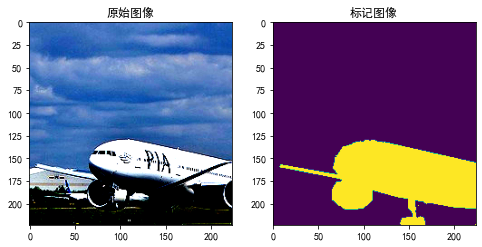

In [60]:
x = np.array(voc_train[9][0]).transpose(1,2,0)
y = np.array(voc_train[9][1])
print(np.shape(y))
fig, axs = plt.subplots(1, 2, figsize = (8, 8))
axs[0].imshow(x)
axs[0].set_title("原始图像")
axs[1].imshow(y)
axs[1].set_title("标记图像")
plt.show()

**构造kernel：**

>使用双线性插值的方法构造kernel，通过一个只依赖于输入和输出单元的相对位置的线性映射，从最近的四个输入计算每个输出$y_{ij}$

<img src="./CC_1.png" width="30%" align=left> <img src="./CC_2.png" width="60%" align=left>

In [11]:
def bilinear_kernel(in_channels, out_channels, kernel_size):
    '''
    return a bilinear filter tensor
    '''
    factor = (kernel_size + 1) // 2
    if kernel_size % 2 == 1:
        center = factor - 1
    else:
        center = factor - 0.5
    og = np.ogrid[:kernel_size, :kernel_size]
    # 生成横向和纵向的0-kernel_size、步长为一的两个二维数组
    filt = (1 - abs(og[0] - center) / factor) * (1 - abs(og[1] - center) / factor)
    weight = np.zeros((in_channels, out_channels, kernel_size, kernel_size), dtype='float32')
    weight[range(in_channels), range(out_channels), :, :] = filt
    return torch.from_numpy(weight)

**载入预训练的残差网络(Resnet34):**

>何凯明2015年提出了残差神经网络，即Reset，并在ILSVRC-2015的分类比赛中获得冠军。  
ResNet可以有效的消除卷积层数增加带来的梯度弥散或梯度爆炸问题。  
ResNet的核心思想是网络输出分为2部分恒等映射（identity mapping）、残差映射（residual mapping），即$y = x + F(x)$。  
><img src="./CC_3.png" width="30%" align=left>  
ResNet通过改变学习目标，即由学习完整的输出变为学习残差，解决了传统卷积在信息传递时存在的信息丢失核损耗问题，通过将输入直接绕道传递到输出，保护了信息的完整性。此外学习目标的简化也降低了学习难度。

In [12]:
model_urls = {
    'resnet18': 'https://download.pytorch.org/models/resnet18-5c106cde.pth',
    'resnet34': 'https://download.pytorch.org/models/resnet34-333f7ec4.pth',
    'resnet50': 'https://download.pytorch.org/models/resnet50-19c8e357.pth',
    'resnet101': 'https://download.pytorch.org/models/resnet101-5d3b4d8f.pth',
    'resnet152': 'https://download.pytorch.org/models/resnet152-b121ed2d.pth',
}

# 使用预训练的resnet 34（34层残差网络）代替论文中的vgg实现fcn
model_root = "./model/resnet34-333f7ec4.pth"
pretrained_net = models.resnet34(pretrained=False)
pre = torch.load(model_root)
pretrained_net.load_state_dict(pre)
# 分类的总数
num_classes = len(classes)

**构建全卷积神经网络（FCN）模型：**  

<img src="./CC_4.png" width="100%" align=left>

<img src="./CC_5.png" width="60%" align=left>

In [13]:
class fcn(nn.Module):
    def __init__(self, num_classes):
        super(fcn, self).__init__()

        # 第一段，通道数为128，输出特征图尺寸为28*28
        # conv1, conv2_x, conv3_x
        self.stage1 = nn.Sequential(*list(pretrained_net.children())[:-4])
        # 第二段，通道数为256，输出特征图尺寸为14*14
        # conv4_x
        self.stage2 = list(pretrained_net.children())[-4]
        # 第三段，通道数为512，输出特征图尺寸为7*7
        # conv5_x
        self.stage3 = list(pretrained_net.children())[-3]

        # 三个kernel为1*1的卷积操作，各个通道信息融合
        self.scores1 = nn.Conv2d(512, num_classes, 1)
        self.scores2 = nn.Conv2d(256, num_classes, 1)
        self.scores3 = nn.Conv2d(128, num_classes, 1)

        # 反卷积，将特征图尺寸放大八倍
        self.upsample_8x = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=16, stride=8, padding=4, bias=False)
        self.upsample_8x.weight.data = bilinear_kernel(num_classes, num_classes, 16)

        # 反卷积，将特征图尺寸放大两倍
        self.upsample_2x_1 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample_2x_1.weight.data = bilinear_kernel(num_classes, num_classes, 4)
        self.upsample_2x_2 = nn.ConvTranspose2d(num_classes, num_classes, kernel_size=4, stride=2, padding=1, bias=False)
        self.upsample_2x_2.weight.data = bilinear_kernel(num_classes, num_classes, 4)

    def forward(self, x):
        x = self.stage1(x)
        s1 = x  # 224/8 = 28

        x = self.stage2(x)
        s2 = x  # 224/16 = 14

        x = self.stage3(x)
        s3 = x  # 224/32 = 7

        # 将各通道信息融合
        s3 = self.scores1(s3)
        # 上采样 放大二倍
        s3 = self.upsample_2x_1(s3)

        s2 = self.scores2(s2)
        # 将二三层训练特征合成 14*14
        s2 = s2 + s3
        s2 = self.upsample_2x_2(s2)

        # 28*28
        s1 = self.scores3(s1)
        # 将一二三层训练特征合成 28*28
        s = s1 + s2
        # 将s放大八倍，变为原图像尺寸 224*224
        s = self.upsample_8x(s)

        # 返回特征图
        return s

In [30]:
print(net)

fcn(
  (stage1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    

**模型评价指标：**

<img src="./CC_6.png" width="75%" align=left>

In [15]:
# 计算混淆矩阵
def _fast_hist(label_true, label_pred, n_class):
    # mask在和label_true相对应的索引的位置上填入true或者false
    # label_true[mask]会把mask中索引为true的元素输出
    mask = (label_true >= 0) & (label_true < n_class)
    hist = np.bincount(
        n_class * label_true[mask].astype(int) +
        label_pred[mask], minlength=n_class ** 2).reshape(n_class, n_class)
    return hist


"""
label_trues 正确的标签值
label_preds 模型输出的标签值
n_class 数据集中的分类数
"""
def label_accuracy_score(label_trues, label_preds, n_class):
    """Returns accuracy score evaluation result.
      - overall accuracy
      - mean accuracy
      - mean IU
      - fwavacc
    """
    hist = np.zeros((n_class, n_class))
    # 通过迭代器将一个个数据进行计算
    for lt, lp in zip(label_trues, label_preds):
        hist += _fast_hist(lt.flatten(), lp.flatten(), n_class)

    # np.diag(a)假如a是一个二维矩阵，那么会输出矩阵的对角线元素
    # np.sum()可以计算出所有元素的和。如果axis=1，则表示按行相加
    acc = np.diag(hist).sum() / hist.sum()
    # np.diag 以一维数组的形式返回方阵的对角线
    acc_cls = np.diag(hist) / hist.sum(axis=1)
    # nanmean会自动忽略nan的元素求平均
    acc_cls = np.nanmean(acc_cls)
    iu = np.diag(hist) / (hist.sum(axis=1) + hist.sum(axis=0) - np.diag(hist))
    mean_iu = np.nanmean(iu)
    freq = hist.sum(axis=1) / hist.sum()
    fwavacc = (freq[freq > 0] * iu[freq > 0]).sum()
    
    return acc, acc_cls, mean_iu, fwavacc

**定义超参数及保存训练数据：**

In [16]:
net = fcn(num_classes)
PATH = "./model/fcn-resnet34.pth"
net.load_state_dict(torch.load(PATH))
if torch.cuda.is_available():
    net = net.cuda()

# 训练时的数据
train_loss = []
train_acc = []
train_acc_cls = []
train_mean_iu = []
train_fwavacc = []

# 验证时的数据
eval_loss = []
eval_acc = []
eval_acc_cls = []
eval_mean_iu = []
eval_fwavacc = []

In [17]:
# 损失
criterion = nn.NLLLoss()

# 加速器 sgd
Eta = 1e-2
basic_optim = torch.optim.SGD(net.parameters(), lr=Eta, weight_decay=1e-4)
optimizer = basic_optim

# 网络训练
EPOCHES = 60

exp_lr_scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

**模型训练：**

In [19]:
for e in range(EPOCHES):
    
    _train_loss = 0  # 记录一轮训练总损失
    _train_acc = 0
    _train_acc_cls = 0
    _train_mean_iu = 0
    _train_fwavacc = 0
    exp_lr_scheduler.step()
    prev_time = datetime.now()
    net = net.train()
    for img_data, img_label in train_data:
        if torch.cuda.is_available():
            im = Variable(img_data).cuda()
            label = torch.tensor(img_label, dtype=torch.int64)
            label = Variable(label).cuda()
        else:
            im = Variable(img_data)
            label = torch.tensor(img_label, dtype=torch.int64)
            label = Variable(label)

        # 前向传播
        out = net(im)
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)
        
        # 反向传播
        # 梯度清零
        optimizer.zero_grad()
        loss.backward()
        # 更新
        optimizer.step()
        _train_loss += loss.item()

        # label_pred输出的是21*224*224的向量，对于每一个点都有21个分类的概率
        # 我们取概率值最大的那个下标作为模型预测的标签，然后计算各种评价指标
        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        # label_pred: (8, 224, 224) label_true: (8, 224, 224)
        for lbt, lbp in zip(label_true, label_pred):
            # lbt: (224, 224) lbp: (224, 224)
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            _train_acc += acc
            _train_acc_cls += acc_cls
            _train_mean_iu += mean_iu
            _train_fwavacc += fwavacc

    # 记录当前轮的数据
    train_loss.append(_train_loss / len(train_data))
    train_acc.append(_train_acc / len(voc_train))
    train_acc_cls.append(_train_acc_cls)
    train_mean_iu.append(_train_mean_iu / len(voc_train))
    train_fwavacc.append(_train_fwavacc)

    net = net.eval()

    _eval_loss = 0
    _eval_acc = 0
    _eval_acc_cls = 0
    _eval_mean_iu = 0
    _eval_fwavacc = 0

    for img_data, img_label in valid_data:
        if torch.cuda.is_available():
            im = Variable(img_data).cuda()
            label = torch.tensor(img_label, dtype=torch.int64)
            label = Variable(label).cuda()
        else:
            im = Variable(img_data)
            label = torch.tensor(img_label, dtype=torch.int64)
            label = Variable(label)

        # forward
        out = net(im)
        # 对结果进行归一化
        out = F.log_softmax(out, dim=1)
        loss = criterion(out, label)
        _eval_loss += loss.item()

        label_pred = out.max(dim=1)[1].data.cpu().numpy()
        label_true = label.data.cpu().numpy()
        for lbt, lbp in zip(label_true, label_pred):
            acc, acc_cls, mean_iu, fwavacc = label_accuracy_score(lbt, lbp, num_classes)
            _eval_acc += acc
            _eval_acc_cls += acc_cls
            _eval_mean_iu += mean_iu
            _eval_fwavacc += fwavacc

    # 记录当前轮的数据
    eval_loss.append(_eval_loss / len(valid_data))
    eval_acc.append(_eval_acc / len(voc_test))
    eval_acc_cls.append(_eval_acc_cls)
    eval_mean_iu.append(_eval_mean_iu / len(voc_test))
    eval_fwavacc.append(_eval_fwavacc)

    # 打印当前轮训练的结果
    cur_time = datetime.now()
    h, remainder = divmod((cur_time - prev_time).seconds, 3600)
    # divmod() 函数返回当参数 1 除以参数 2 时包含商和余数的元组。
    m, s = divmod(remainder, 60)
    epoch_str = ('Epoch: {}, Train Loss: {:.5f}, Train Acc: {:.5f}, Train Mean IU: {:.5f}, '
                 'Valid Loss: {:.5f}, Valid Acc: {:.5f}, Valid Mean IU: {:.5f} '.format(
        e, _train_loss / len(train_data), _train_acc / len(voc_train), _train_mean_iu / len(voc_train),
           _eval_loss / len(valid_data), _eval_acc / len(voc_test), _eval_mean_iu / len(voc_test)))
    time_str = 'Time: {:.0f}:{:.0f}:{:.0f}'.format(h, m, s)
    print(epoch_str + time_str)

C:\ProgramData\Anaconda3\envs\pytorch\lib\site-packages\torch\optim\lr_scheduler.py:129: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "
C:\Users\14103\AppData\Local\Temp\ipykernel_20796\3431214768.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  label = torch.tensor(img_label, dtype=torch.int64)
C:\Users\14103\AppData\Local\Temp\ipykernel_20796\1340854645.py:36: RuntimeWarning: invalid value encountered in true_d

Epoch: 0, Train Loss: 0.04246, Train Acc: 0.98331, Train Mean IU: 0.89449, Valid Loss: 0.49097, Valid Acc: 0.89395, Valid Mean IU: 0.57088 Time: 0:0:41
Epoch: 1, Train Loss: 0.04334, Train Acc: 0.98308, Train Mean IU: 0.89284, Valid Loss: 0.49525, Valid Acc: 0.89504, Valid Mean IU: 0.57493 Time: 0:0:40
Epoch: 2, Train Loss: 0.04284, Train Acc: 0.98318, Train Mean IU: 0.89390, Valid Loss: 0.49682, Valid Acc: 0.89211, Valid Mean IU: 0.56155 Time: 0:0:40
Epoch: 3, Train Loss: 0.04289, Train Acc: 0.98316, Train Mean IU: 0.89441, Valid Loss: 0.49863, Valid Acc: 0.89424, Valid Mean IU: 0.57370 Time: 0:0:41
Epoch: 4, Train Loss: 0.04269, Train Acc: 0.98325, Train Mean IU: 0.89244, Valid Loss: 0.49014, Valid Acc: 0.89289, Valid Mean IU: 0.56379 Time: 0:0:41
Epoch: 5, Train Loss: 0.04212, Train Acc: 0.98343, Train Mean IU: 0.89526, Valid Loss: 0.50790, Valid Acc: 0.89345, Valid Mean IU: 0.57426 Time: 0:0:42
Epoch: 6, Train Loss: 0.04193, Train Acc: 0.98347, Train Mean IU: 0.89395, Valid Loss: 0

Epoch: 54, Train Loss: 0.04200, Train Acc: 0.98345, Train Mean IU: 0.89591, Valid Loss: 0.50077, Valid Acc: 0.89416, Valid Mean IU: 0.57140 Time: 0:0:42
Epoch: 55, Train Loss: 0.04243, Train Acc: 0.98343, Train Mean IU: 0.89496, Valid Loss: 0.49795, Valid Acc: 0.89415, Valid Mean IU: 0.57136 Time: 0:0:42
Epoch: 56, Train Loss: 0.04201, Train Acc: 0.98350, Train Mean IU: 0.89607, Valid Loss: 0.49383, Valid Acc: 0.89414, Valid Mean IU: 0.57102 Time: 0:0:45
Epoch: 57, Train Loss: 0.04168, Train Acc: 0.98360, Train Mean IU: 0.89597, Valid Loss: 0.49616, Valid Acc: 0.89416, Valid Mean IU: 0.57233 Time: 0:0:43
Epoch: 58, Train Loss: 0.04195, Train Acc: 0.98345, Train Mean IU: 0.89411, Valid Loss: 0.50202, Valid Acc: 0.89381, Valid Mean IU: 0.57606 Time: 0:0:42
Epoch: 59, Train Loss: 0.04188, Train Acc: 0.98356, Train Mean IU: 0.89581, Valid Loss: 0.50403, Valid Acc: 0.89396, Valid Mean IU: 0.57191 Time: 0:0:48


**保存模型训练结果：**

In [46]:
PATH = "./model/fcn-resnet34.pth"
torch.save(net.state_dict(), PATH)

**绘制训练数据评价曲线：**

Text(0.5, 1.0, 'Mean IU')

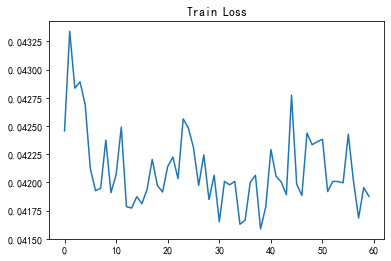

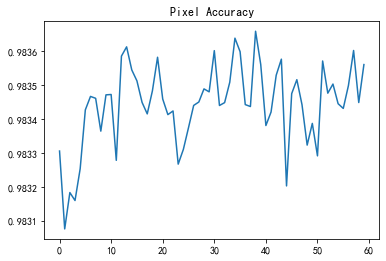

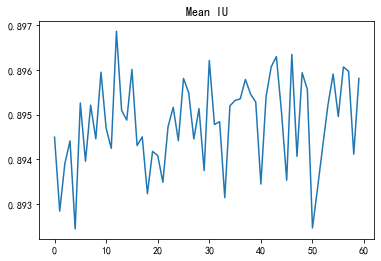

In [31]:
plt.plot(np.array(train_loss))
plt.title("Train Loss")
plt.figure()
plt.plot(np.array(train_acc))
plt.title("Pixel Accuracy")
plt.figure()
plt.plot(np.array(train_mean_iu))
plt.title("Mean IU")

<img src="./CC_7.png" width="75%" align=left>

**测试集训练结果：**

可以看出我们模型89.4%的准确率与论文中的数据较为接近。  
<img src="./CC_8.png" width="50%" align=left>

In [45]:
print("Eval Pixel Accuracy: ", np.array(eval_acc)[-1])
print("Eval Mean IU: ", np.array(eval_mean_iu)[-1])

Eval Pixel Accuracy:  0.8944751938358038
Eval Mean IU:  0.5766601620395866


**可视化测试集预测结果：**

In [28]:
# 加载模型
net = fcn(num_classes)
PATH = "./model/fcn-resnet34.pth"
net.load_state_dict(torch.load(PATH))
if torch.cuda.is_available():
    net = net.cuda()
cm = np.array(colormap).astype('uint8')
size = 224
num_image = 10

In [29]:
def predict(img, label):  # 预测结果
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    # 将pred的分类值，转换成各个分类对应的RGB值
    pred = cm[pred]
    # 将numpy转换成PIL对象
    pred = Image.fromarray(pred)
    label = cm[label.numpy()]
    return pred, label

Text(0.5, -0.2, 'fcns')

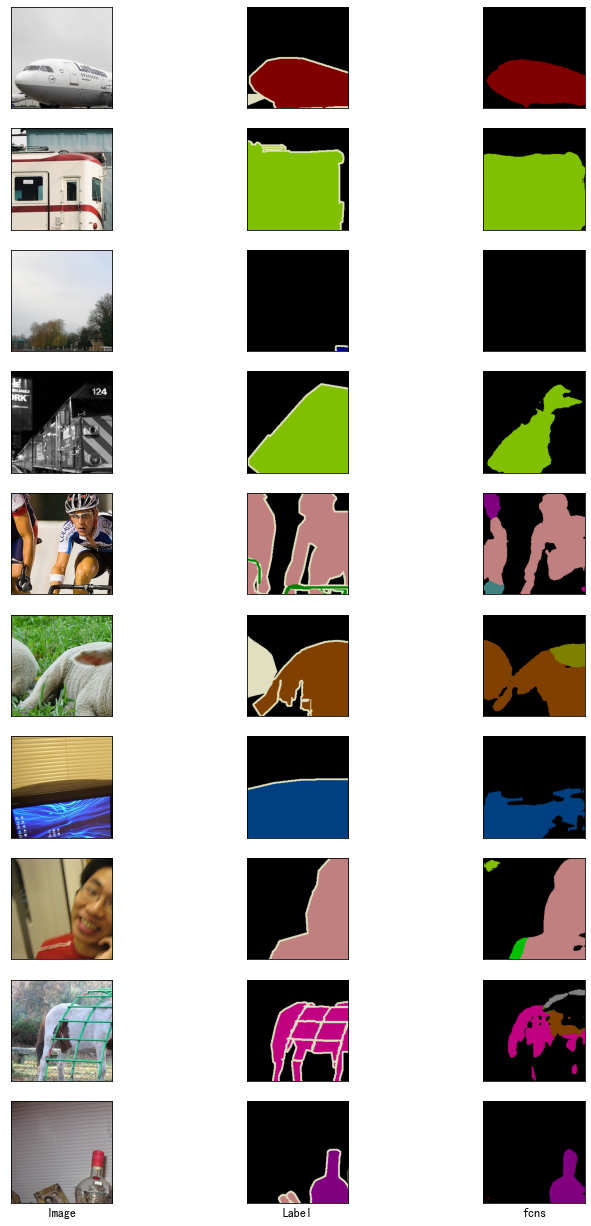

In [83]:
_, figs = plt.subplots(num_image, 3, figsize=(12, 22))
for i in range(num_image):
    img_data, img_label = voc_test[i]
    pred, label = predict(img_data, img_label)
    img_data = Image.open(voc_test.data_list[i])
    img_label = Image.open(voc_test.label_list[i]).convert("RGB")
    img_data, img_label = crop_image(img_data, img_label, 224, 224)
    figs[i, 0].imshow(img_data)  # 原始图片
    figs[i, 0].axes.get_xaxis().set_visible(False)  # 去掉x轴
    figs[i, 0].axes.get_yaxis().set_visible(False)  # 去掉y轴
    figs[i, 1].imshow(img_label)  # 标签
    figs[i, 1].axes.get_xaxis().set_visible(False)  # 去掉x轴
    figs[i, 1].axes.get_yaxis().set_visible(False)  # 去掉y轴
    figs[i, 2].imshow(pred)  # 模型输出结果
    figs[i, 2].axes.get_xaxis().set_visible(False)  # 去掉x轴
    figs[i, 2].axes.get_yaxis().set_visible(False)  # 去掉y轴

# 在最后一行图片下面添加标题
figs[num_image - 1, 0].set_title("Image", y=-0.2)
figs[num_image - 1, 1].set_title("Label", y=-0.2)
figs[num_image - 1, 2].set_title("fcns", y=-0.2)

在这里我们要注意的是FCN的缺点：
是得到的结果还是不够精细。进行8倍上采样虽然比32倍的效果好了很多，但是上采样的结果还是比较模糊和平滑，对图像中的细节不敏感。
是对各个像素进行分类，没有充分考虑像素与像素之间的关系。忽略了在通常的基于像素分类的分割方法中使用的空间规整（spatial regularization）步骤，缺乏空间一致性.

**通过日常相片检测模型分割效果：**

In [104]:
MY_DATA_DIR = '.\\data'

In [105]:
print(os.listdir(MY_DATA_DIR+'\\Mydata')[:10])

['8bad1c24b4e400c000e2636652dcdad.jpg', 'm1.jpg']


In [106]:
Is = os.listdir(MY_DATA_DIR+'\\Mydata')
data = [os.path.join(MY_DATA_DIR, 'Mydata', i) for i in Is]

In [107]:
data

['.\\data\\Mydata\\8bad1c24b4e400c000e2636652dcdad.jpg',
 '.\\data\\Mydata\\m1.jpg']

In [108]:
height = 896
width = 896

In [109]:
def My_Image(data, height, width):
    img = []
    for im in data:
        if (Image.open(im).size[1] >= height and Image.open(im).size[0] >= width):
            img.append(im)
    img = [Image.open(i) for i in img]
    box = (0, 0, width, height)
    img = [i.crop(box) for i in img]
    im_tfs = tfs.Compose([
            tfs.ToTensor(),
            tfs.Normalize(
                mean=[0.485, 0.456, 0.406],
                std=[0.229, 0.224, 0.225])
    ])
    img = [im_tfs(i) for i in img]
    return img

In [110]:
img = My_Image(data, height, width)

In [111]:
def predict_(img):
    img = Variable(img.unsqueeze(0)).cuda()
    out = net(img)
    pred = out.max(1)[1].squeeze().cpu().data.numpy()
    pred = cm[pred]
    pred = Image.fromarray(pred)
    return pred

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


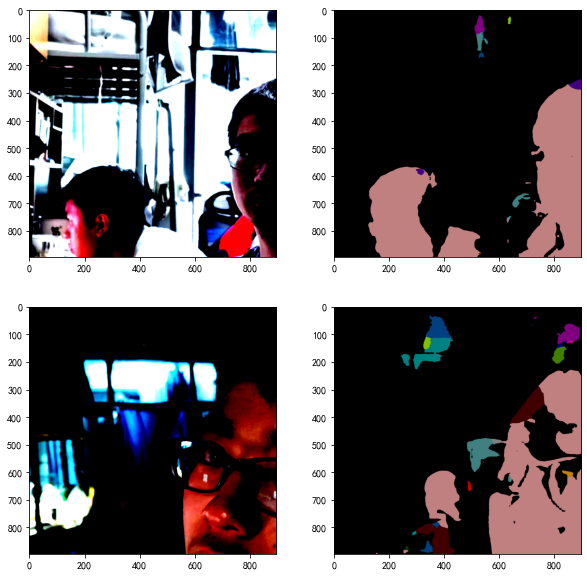

In [115]:
_, figs = plt.subplots(len(data), 2, figsize=(10, 10))
for i in range(len(data)):
    pred = predict_(img[i])
    figs[i, 0].imshow(img[i].data.numpy().transpose(1,2,0))
    figs[i, 1].imshow(pred)